This kernel used data derived from ```stock_price.py```

The aim of this kernel is to analyze stock recomendation (sell, buy or hold), which action should we take while the external features are changed. These features include the stock prices of other companies. 

In [1]:
import quandl
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [3]:
quandl.ApiConfig.api_key = 'o-yXuCnVqzcxKcUzc6vb'

# Load data

In [4]:
with open("data/compiled_data.pkl", "rb") as f:
    joined_price_data = pickle.load(f)

In [5]:
joined_price_data.head()

,AAPL,AMZN,JPM,MSFT,TSLA
Date,,,,,
2013-01-02,71.777153,257.3100,39.829227,24.583819,35.36
2013-01-03,70.870627,258.4800,39.748962,24.254492,34.77
2013-01-04,68.897072,259.1500,40.453510,23.800555,34.40
2013-01-07,68.491795,268.4592,40.498102,23.756051,34.34
2013-01-08,68.676131,266.3800,40.578366,23.631441,33.68


In [6]:
joined_price_data.shape

(1008, 5)

# Prepare data

This part is motivated by [Sentdex](https://pythonprogramming.net/targets-for-machine-learning-labels-python-programming-for-finance/?completed=/preprocessing-for-machine-learning-python-programming-for-finance/)

In [7]:
def process_data_for_labels(ticker):
    '''
    Compute the change in price within x days (x <= 7)
    The label whether buy, sell, hold will be decided based on these information
    '''
    hm_days = 7
    df = joined_price_data
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1,hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df

If the movement:
- Larger than ```requirement```: buy. 
- Lower than -```requirement```: sell. 
- None of the above: hold

In [8]:
def buy_sell_hold(*args):
    '''
    1: buy, -1: sell, 0: hold
    '''
    cols = [c for c in args]
    requirement = 0.02 #change in stock price
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

In [9]:
def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)] ))
   
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:',Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X,y,df, df_vals

In [10]:
X, y, df, df_vals = extract_featuresets('AAPL')

Data spread: Counter({'1': 419, '-1': 393, '0': 196})


In [11]:
X.shape

(1008, 5)

In [12]:
y

array([-1, -1, -1, ...,  0,  0,  0])

In [13]:
df.head()

,AAPL,AMZN,JPM,MSFT,TSLA,AAPL_1d,AAPL_2d,AAPL_3d,AAPL_4d,AAPL_5d,AAPL_6d,AAPL_7d,AAPL_target
Date,,,,,,,,,,,,,
2013-01-02,71.777153,257.3100,39.829227,24.583819,35.36,-0.012630,-0.040125,-0.045772,-0.043203,-0.058157,-0.046482,-0.052329,-1
2013-01-03,70.870627,258.4800,39.748962,24.254492,34.77,-0.027847,-0.033566,-0.030965,-0.046110,-0.034285,-0.040207,-0.074426,-1
2013-01-04,68.897072,259.1500,40.453510,23.800555,34.40,-0.005882,-0.003207,-0.018786,-0.006622,-0.012713,-0.047913,-0.077951,-1
2013-01-07,68.491795,268.4592,40.498102,23.756051,34.34,0.002691,-0.012980,-0.000744,-0.006872,-0.042279,-0.072495,-0.033995,-1
2013-01-08,68.676131,266.3800,40.578366,23.631441,33.68,-0.015629,-0.003427,-0.009537,-0.044850,-0.074984,-0.036588,-0.043079,-1


# Make prediction

In [14]:
def modelTest(clf, train, labels):
    '''Compute cross-validation score to see the goodness of each model'''
    cv = KFold(n_splits=5,shuffle=True,random_state=7).split(train)
    accuracy = make_scorer(accuracy_score)
    crossed_score = cross_val_score(clf, train, labels, cv=cv, scoring=accuracy)
    score=[crossed_score.mean()]
    return score

In [15]:
def modelPlot(result_dict):
    '''Plot the accuracy of all model'''
    result = pd.DataFrame.from_dict(result_dict, orient='index')
    result.columns = ["Score"] 
    #result = result.sort(columns=["Score"],ascending=False)
    result = result.sort_values(by=["Score"],ascending=False)
    result.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0,1])
    return result

In [16]:
def modelFit(train, labels):
    '''Train model'''
    result_dict = {}
    
    clf = svm.SVC(kernel='rbf')
    result_dict["SVM RBF"] = modelTest(clf, train, labels)
    
    clf = svm.SVC(kernel='linear')
    result_dict["SVM Linear"] = modelTest(clf, train, labels)
    
    clf = RandomForestClassifier()
    result_dict["Random Forest"] = modelTest(clf, train, labels)
    
    clf = GradientBoostingClassifier()
    result_dict["Gradiend Boosting"] = modelTest(clf, train, labels)
    
    clf = AdaBoostClassifier()
    result_dict["Ada Boost"] = modelTest(clf, train, labels)
    
    model_summary = modelPlot(result_dict)
    return model_summary

,Score
SVM RBF,0.415694
SVM Linear,0.415694
Ada Boost,0.399798
Random Forest,0.394818
Gradiend Boosting,0.392882


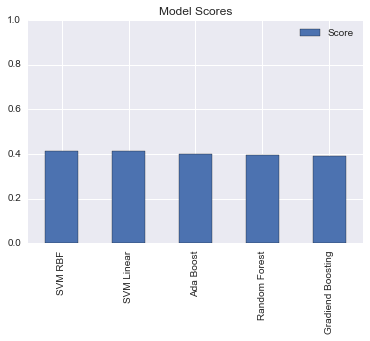

In [17]:
modelFit(X, y)

The result reveals that using prediction model can improve the performance rather than randomly choosing